In [18]:
import random

import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from keras.layers import *
from keras.losses import cosine_proximity, categorical_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
from acquisition import get_trainset_list, prep_data
from Pyramid import Pyramid

In [19]:
# Custom loss layer
class CustomDistanceLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomDistanceLossLayer, self).__init__(**kwargs)

    def distance_loss(self, anchor, positive, negative):
        l2_anchor = K.l2_normalize(anchor, axis=1)
        l2_positive = K.l2_normalize(positive, axis=1)
        l2_negative = K.l2_normalize(negative, axis=1)
        loss = cosine_proximity(l2_anchor, l2_positive) - cosine_proximity(l2_anchor, l2_negative) # environ 10 max next time increase factor value
        return K.mean(loss, axis=-1) / 10

    def call(self, inputs):
        x = inputs[0]
        positive = inputs[1]
        negative = inputs[2]
        loss = self.distance_loss(x, positive, negative)
        self.add_loss(loss, inputs=inputs)
        return x

In [20]:
# Custom loss layer
class CustomFinalLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomFinalLossLayer, self).__init__(**kwargs)

    def final_loss(self, image, label, image_decoded, label_predicted):
        # environ 15 max
        loss = (K.mean(categorical_crossentropy(label, label_predicted), axis=-1) / 15) \
             + (K.mean(mean_squared_error(image, image_decoded), axis=-1) / 20000) # environ 20000 max
        return loss

    def call(self, inputs):
        image = inputs[0]
        label = inputs[1]
        image_decoded = inputs[2]
        label_predicted = inputs[3]
        loss = self.final_loss(image, label, image_decoded, label_predicted)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return label_predicted

In [21]:
pool_func = MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")

conv_1_func = Conv2D(filters=4, kernel_size=(5, 5), strides=1, padding="same", activation="relu")
conv_2_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
fully_connected = Dense(2, activation="softmax")

input_layer = Input(shape=(36, 36, 1))
conv_1 = conv_1_func(input_layer)
pool_1 = pool_func(conv_1)
conv_2 = conv_2_func(pool_1)
pool_2 = pool_func(conv_2)
to_be_densed = Flatten()(pool_2)

encoder = Model(input_layer, to_be_densed, name='encoder')

anchor = Input(shape=(36, 36, 1))
positive = Input(shape=(36, 36, 1))
negative = Input(shape=(36, 36, 1))
labels = Input(shape=(2,))

cosine_loss = CustomDistanceLossLayer()([encoder(anchor), encoder(positive), encoder(negative)])

upsample = UpSampling2D()


conv_3_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
reshaping = Reshape((9, 9, 2))
conv_4_func = Conv2D(filters=2, kernel_size=(3, 3), strides=1, padding="same", activation="relu")
conv_5_func = Conv2D(filters=1, kernel_size=(5, 5), strides=1, padding="same", activation="relu")

input_decoder = Input((162,))
reshaped = reshaping(input_decoder)
conv_3 = conv_3_func(reshaped)
up_1 = upsample(conv_3)
conv_4 = conv_4_func(up_1)
up_2 = upsample(conv_4)
output_decoder = conv_5_func(up_2)

decoder = Model(input_decoder, output_decoder, name='decoder')

autoencoder_output = decoder(cosine_loss)

output_categorical_layer = fully_connected(cosine_loss)

output = CustomFinalLossLayer()([anchor, labels, autoencoder_output, output_categorical_layer])
model = Model([anchor, positive, negative, labels], [output], name='full network')

In [22]:

model.load_weights('full_autoencoder0.95.wnn')

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 36, 36, 1)     0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 36, 36, 1)     0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 36, 36, 1)     0                                            
____________________________________________________________________________________________________
encoder (Model)                  (None, 162)           178         input_2[0][0]                    
                                                                   input_3[0][0]           

In [7]:
model.compile('adam', None, ['accuracy'])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: UserWarning: Output "custom_final_loss_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_final_loss_layer_1" during training.
  if __name__ == '__main__':


In [8]:
elements_number = 50

anchors_positive, positive_labels, anchors_negative, negative_labels = get_trainset_list(elements_number, elements_number)

anchors = np.concatenate((anchors_positive, anchors_negative), axis=0)

anchors_labels = np.concatenate((positive_labels, negative_labels))

indices = list(range(len(anchors)))

random.shuffle(indices)

anchors = np.expand_dims(prep_data(anchors[indices]), axis=3)
anchors_labels = np.asarray(list(map(lambda x: int(x), anchors_labels[indices])))


acquisition::get_trainset_list : positive_sample : ['start_deep/train_images/1/Image229911.pgm', 'start_deep/train_images/1/Image020734.pgm', 'start_deep/train_images/1/Image004411.pgm', 'start_deep/train_images/1/Image017614.pgm', 'start_deep/train_images/1/Image025080.pgm', 'start_deep/train_images/1/Image133919.pgm', 'start_deep/train_images/1/Image024558.pgm', 'start_deep/train_images/1/Image114393.pgm', 'start_deep/train_images/1/Image130233.pgm', 'start_deep/train_images/1/Image211698.pgm']
acquisition::get_trainset_list : negative_sample : ['start_deep/train_images/0_added/0.95/IMG_3_0_1.png'
 'start_deep/train_images/0_added/0.95/IMG_89_7_40.png'
 'start_deep/train_images/0_added/0.95/IMG_90_8_26.png'
 'start_deep/train_images/0_added/0.95/IMG_81_2_11.png'
 'start_deep/train_images/0_added/0.999/IMG_98_2_1.png'
 'start_deep/train_images/0_added/0.99/IMG_224_9_10.png'
 'start_deep/train_images/0_added/0.95/IMG_89_73_29.png'
 'start_deep/train_images/0_added/0.95/IMG_93_18_48.png

In [27]:
def select_triplets(anchors, labels):
    anchors_embeddings = encoder.predict(anchors)
    distances = cdist(anchors_embeddings, anchors_embeddings, metric='cosine')
    positives_labels = []
    negatives_labels = []
    for i, line in enumerate(distances):
        positives_distances = line.copy()
        positives_distances[np.where(labels!=labels[i])] *= 0
        max_positive = positives_distances.max()
        positives_labels.append(np.argmax(positives_distances))
        negative_distances = line.copy()
        if(max_positive != line.max()):
            negative_distances[np.where(negative_distances<=max_positive)] *= 5000
        negative_distances[np.where(labels==labels[i])] *= 5000
        negative_distances[i] = 5000000
        negatives_labels.append(np.argmin(negative_distances))
        
    return [anchors, anchors.copy()[positives_labels], anchors.copy()[negatives_labels], to_categorical(labels)]

In [28]:
for i in range(60):
    model.fit(x=select_triplets(anchors, anchors_labels), batch_size=50, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 12s - loss: 0.5754     

KeyboardInterrupt: 

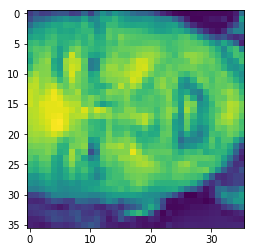

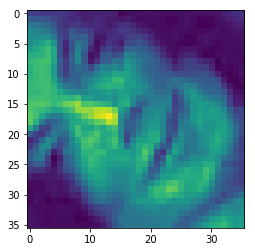

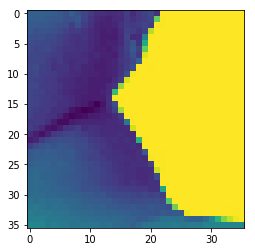

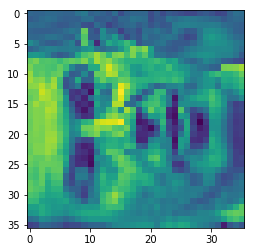

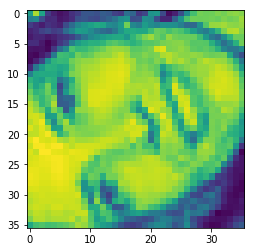

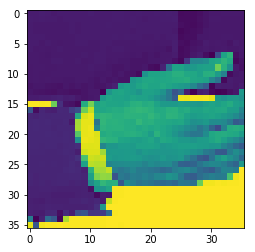

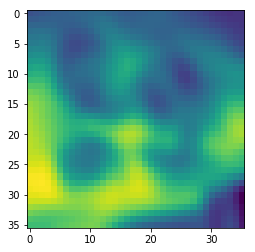

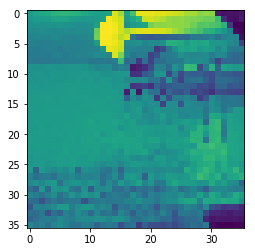

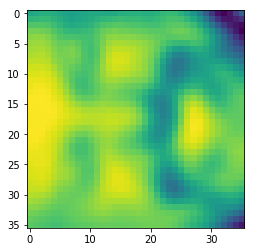

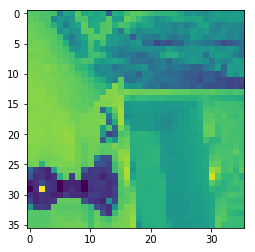

In [11]:
for i in range(10):
    plt.imshow(anchors[i, :, :, 0])
    plt.show()

In [12]:
encoding = encoder.predict(anchors[1:2])

In [13]:
decoded = decoder.predict(encoding)

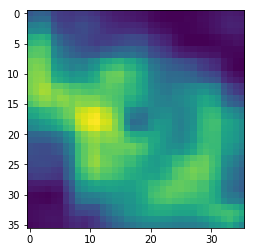

In [14]:
plt.imshow(decoded[0, :, :, 0])
plt.show()

In [10]:
anchors_labels[:10]

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 0])

In [53]:
model.predict([anchors[0:10], np.zeros((10, 36, 36, 1)), np.zeros((10, 36, 36, 1)), np.zeros((10,2))])

array([[  9.99999762e-01,   2.43433874e-07],
       [  4.96595204e-01,   5.03404796e-01],
       [  9.96751189e-01,   3.24878795e-03],
       [  3.29405397e-01,   6.70594573e-01],
       [  7.84530997e-01,   2.15468988e-01],
       [  9.99949336e-01,   5.06770848e-05],
       [  9.99930024e-01,   6.99387601e-05],
       [  9.99777615e-01,   2.22382645e-04],
       [  9.43356157e-12,   1.00000000e+00],
       [  3.17268018e-06,   9.99996781e-01]], dtype=float32)

In [15]:
encoding_p1 = encoder.predict(anchors[0:1])
encoding_p2 = encoder.predict(anchors[0:1])
encoding_n1 = encoder.predict(anchors[:10])

In [17]:
for i in range(10):
    print(cosine(encoding_p1/np.linalg.norm(encoding_p1, ord=2, axis=-1), encoding_n1[i]/np.linalg.norm(encoding_n1[i], ord=2, axis=-1)))

-5.96046483281e-08
0.167314956624
0.257427603892
0.106892294102
0.0905568057631
0.37536891552
0.107020908176
0.104054397586
0.0770191642069
0.11994344711


In [262]:
to_categorical(anchors_labels[:10])

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [26]:
input_value = Input(shape=(36, 36, 1))
output_value = fully_connected(encoder(input_value))
model_to_save = Model(input_value, output_value)

In [211]:
model_to_save.predict(anchors[0:10])

array([[  1.16696239e-04,   9.99883294e-01],
       [  9.99940276e-01,   5.96892824e-05],
       [  8.51737440e-01,   1.48262590e-01],
       [  8.31160486e-01,   1.68839484e-01],
       [  7.23679006e-01,   2.76320904e-01],
       [  1.00000000e+00,   4.94688424e-09],
       [  6.09917683e-04,   9.99390125e-01],
       [  8.97917926e-01,   1.02082111e-01],
       [  9.99673363e-03,   9.90003347e-01],
       [  9.99989867e-01,   1.00909510e-05]], dtype=float32)

In [195]:
model.save_weights('full_autoencoder.cnn')

In [27]:
p = Pyramid(model_to_save, 0.999999)

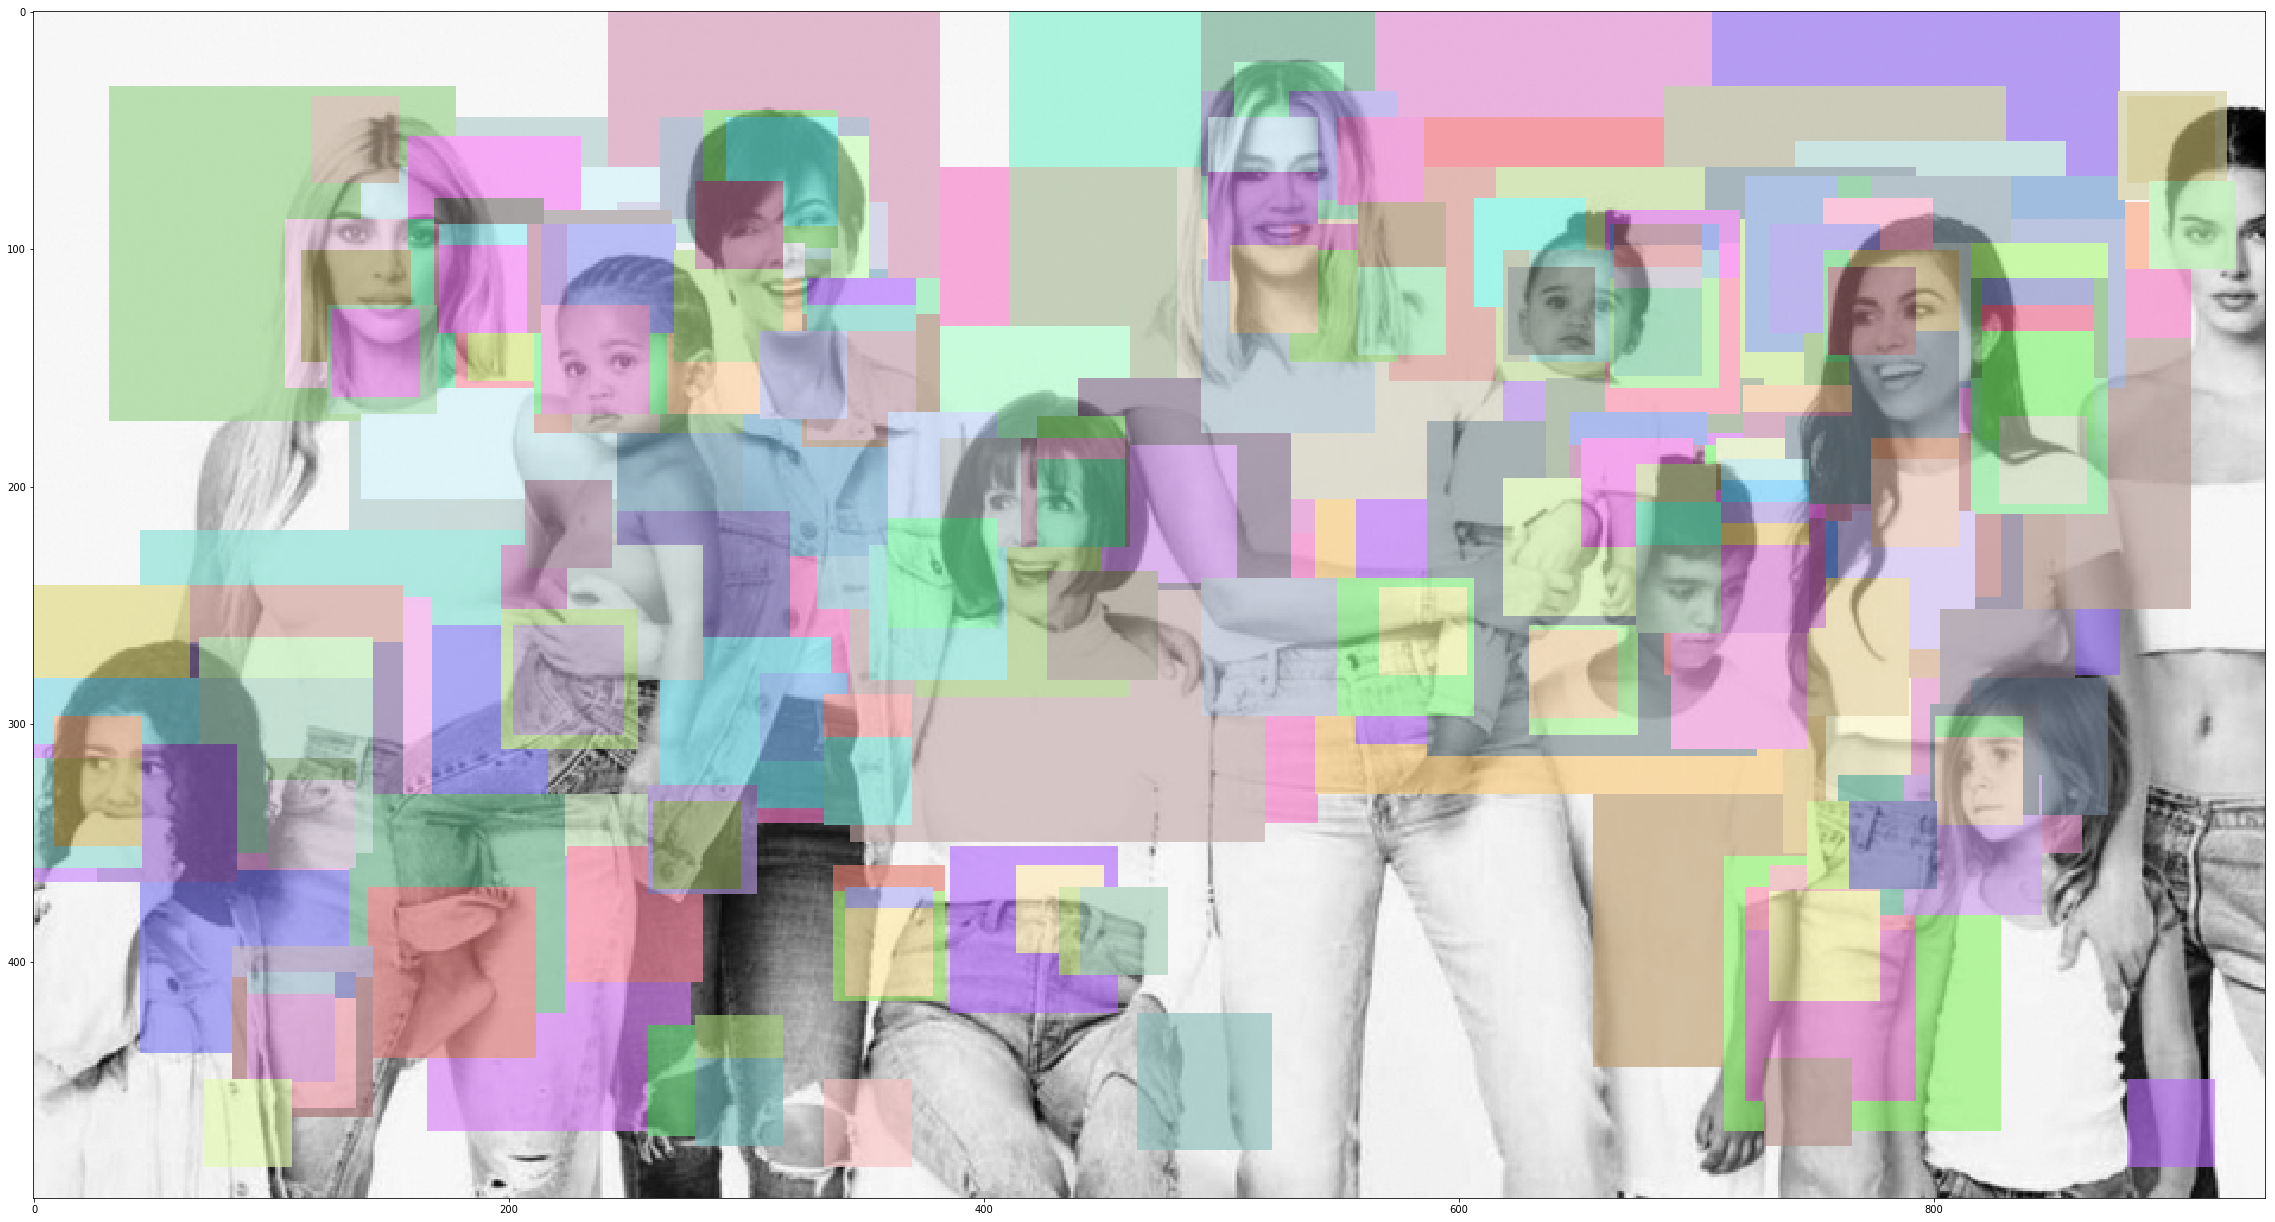

In [29]:
p.test_pyramide("photo_famille2.jpg")